In [1]:
import pandas as pd
from utils import randomSplit, Accumulator
import torch
from torch import nn
import numpy as np
from sklearn.preprocessing import StandardScaler  # 归一化
from sklearn.model_selection import KFold         # k折交叉验
from sklearn.decomposition import PCA             # pca


#import modules
import kmapper as km
import umap
import sklearn
import sklearn.manifold as manifold

import matplotlib.pyplot as plt
from kmapper.jupyter import display

from sklearn.decomposition import PCA
from sklearn import cluster

In [2]:
from torch_geometric.data import Data
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader, NeighborLoader
import random

def rank2class(df):
    if df['LgRk'] <= 6:
        return 0
    elif 6 < df['LgRk'] <= 13:
        return 1
    else:
        return 2
    
def rank2class2(df):
    if df['LgRk'] <= 4: return 0
    elif 4 < df['LgRk'] <= 8:  return 1
    elif 8 < df['LgRk'] <= 12: return 2
    elif 12 < df['LgRk'] <= 16: return 3
    else: return 4
    
class myDataset():
    def __init__(self, renorm=False, pca=False, method='knn', **kargs):
        self.player = pd.read_csv('DLdata\outfielder_combined_from_raw_fillna.csv', header=0, encoding='utf-8')
        self.player = self.player.drop(['Player', 'Comp', 'Age', 'Born'], axis=1)
        # Squad 和 Season 需要保留
        #self.player = self.player.drop(['Rk', 'Player', 'Nation', 'Pos', 'Comp', 'Age', 'Born'], axis=1)
        
        if renorm:
            scaler = StandardScaler()  # z score 归一化
            for col in self.player.columns:
                if col in ('Squad', "Season", 'Pos'): continue
                self.player[[col]] = scaler.fit_transform(self.player[[col]])
        if pca:
            squad = self.player['Squad']
            season = self.player['Season']
            pos = self.player['Pos']
            values = self.player.drop(['Squad', 'Season'], axis=1).values
            comp_dim = kargs['pca_dim']
            pca = PCA(n_components=comp_dim)   # 15
            values = pca.fit_transform(values)
            # print(sum(pca.explained_variance_ratio_))
            self.player = pd.DataFrame(values)
            self.player['Squad'] = squad
            self.player["Season"] = season
            self.player['Pos'] = pos

        self.league = pd.read_excel('DLdata/SquadPerformance2021.xlsx', sheet_name='Sheet1')
        self.league['tier'] = self.league.apply(rank2class, axis=1)
        self.league = self.league[['Squad', 'Season', 'tier']]       

        #initialize mapper
        mapper = km.KeplerMapper(verbose=0)
        #project data
        X_features_numeric = self.player.drop(['Squad', 'Season', 'Pos'], axis=1).values  # data array
        projected_X = mapper.fit_transform(X_features_numeric, 
                                            projection = [manifold.Isomap(n_components=10,n_jobs=-1),
                                                            umap.UMAP(n_components=2,random_state=1)], scaler=[None])  
        graph2 = mapper.map(projected_X, cover=km.Cover(n_cubes=15),
                clusterer=sklearn.cluster.KMeans(n_clusters=5, random_state=1618033))
        self.graph = km.adapter.to_nx(graph2)


        clusters, edges = self.graph.nodes.data(), list(self.graph.edges.data())  # 取出kmapper的数据
        name = dict()
        for edge in edges: # 格式 (edge1, edge2, {})
            name[edge[0]] = 1
            name[edge[1]] = 1
        self.clustersname2index = dict([(v, i) for i, v in enumerate(list(set(name)))])
        self.clusterCount = len(list(self.clustersname2index.values())) # 统计有多少clusters
        self.cluster_features_dim = X_features_numeric.shape[1]


        self.SquadSeasondata = []
        for id in self.league.index:
            squad = self.league.at[id, 'Squad']
            season = self.league.at[id, 'Season']
            tier = self.league.at[id, 'tier']  # 表现数据
            if season == 2021: continue  # 发现github的数据在2021年仅仅只有前几场比赛的，所以不得不舍弃了orzzz
            self.SquadSeasondata.append([squad + str(season), tier])  # list of [squadseason, tier]
            
        self.SquadSeason2index = dict([(v[0], i) for i, v in enumerate(self.SquadSeasondata)])  # 将列表转化为index的字典
        squadSeason_tier = [item[1] for item in self.SquadSeasondata] # id 2 tier 顺序是不变的


        cluster_edges_index = set() # 用set of tuples会更好 ！！
        for edge in edges: # 格式 (edge1, edge2, {})
            cluster_edges_index.add((self.clustersname2index[edge[0]], self.clustersname2index[edge[1]]))
            cluster_edges_index.add((self.clustersname2index[edge[1]], self.clustersname2index[edge[0]]))
        cluster_edges_index = torch.LongTensor(list(cluster_edges_index))  # [num_edges, 2]
        # 遍历每一个 clusters
        cluster_features = torch.zeros((self.clusterCount, self.cluster_features_dim))  # cluster的特征，通过jisuanmenbership的平均值得到
        cluster_e_squad = set()  # 边的集合
        squad_e_cluster = set()
        for clusterdata in clusters:  # nx nodes view
            # 单个cluster example ('cube0_cluster0', {'membership': [2234, 3793, 5864, 6229, 8196]})
            clus_name = clusterdata[0]
            clus_id = self.clustersname2index[clus_name]
            members_l = clusterdata[1]['membership']
            for member in members_l:
                squad = self.player.iloc[member, ]['Squad']
                season = self.player.iloc[member, ]['Season']
                season = str(season).split('-')[0]  # 格式转化与 league数据表中的一一对应
                squadSeasonIndex = self.SquadSeason2index[squad+season]
                cluster_e_squad.add((clus_id, squadSeasonIndex))  # 先cluster再squad，因为考虑信息传递的方向 ？？？？
                squad_e_cluster.add((squadSeasonIndex, clus_id))
            # 生成cluster的特征，先取出对应的menber 的feature，再求平均
            cur_cluster_feature = X_features_numeric[np.array(member), :].mean(axis=0)  # shaoe [1, self.cluster_features_dim]
            cluster_features[clus_id] = cur_cluster_feature  # 可能维度有点对不上需要reshape一下
        cluster_e_squad = torch.LongTensor(list(cluster_e_squad))  # [num_edges, 2]
        squad_e_cluster = torch.LongTensor(list(squad_e_cluster))

        
        self.data = HeteroData()
        self.data['cluster'].x = cluster_features  # [num_clusters, num_features]
        self.data['squad'].y = torch.LongTensor(squadSeason_tier)  # tier数据 [num_squads]
        # 现在必须有一个，即使后面会被重新赋值，不然这个数据集会被认为不完整
        self.data['squad'].x = torch.rand((len(squadSeason_tier), 80))   
        #self.data['squad'].x = torch.rand((len(squadSeason_tier), 10))
        # Create an edge type "(squad, has player in, cluster)" and building the graph connectivity:
        self.data['cluster', 'has player in', 'squad'].edge_index = cluster_e_squad.T  # [2, num_edges]
        self.data['cluster', 'connect', 'cluster'].edge_index = cluster_edges_index.T  # [2, num_edges]
        self.data['squad', 'has player in', 'cluster'].edge_index = squad_e_cluster.T  

        # PyTorch tensor functionality:
        #data = data.pin_memory()
        #data = data.to('cuda:0', non_blocking=True)


    def mask_train_valid(self, train=0.7):
        ran = torch.rand(self.data['squad'].y.shape[0])
        #self.data['squad'].train_mask =  ran < train
        #self.data['squad'].valid_mask = ran >= train
        
    # 使用K折交叉验证
    def DataIter2(self, K=10, shuffle=True):
        # yield train indexs
        KF = KFold(n_splits=K, shuffle=shuffle)
        #self.X = np.array(self.X)  不可以这样转换
        for train_index, valid_index in KF.split(self.data['squad'].y):
            #print("TRAIN", train_index, "TEST", test_index)
            X_train, X_valid = torch.rand(self.data['squad'].y.shape[0]) > 100, torch.rand(self.data['squad'].y.shape[0]) > 100  # 全都是false
            for idx in train_index:
                #X_train.append(idx)
                X_train[idx] = True
            for idx in valid_index:
                #X_valid.append(idx)
                X_valid[idx] = True
            #Y_train, Y_test = self.y[train_index], self.y[test_index]
            #yield torch.LongTensor(X_train), torch.LongTensor(X_valid)
            yield X_train, X_valid

    def DataIter(self, K=10, shuffle=True):
        # yield subgraphs
        KF = KFold(n_splits=K, shuffle=shuffle)
        #self.X = np.array(self.X)  不可以这样转换
        for train_index, valid_index in KF.split(self.data['squad'].y):
            #print("TRAIN", train_index, "TEST", test_index)
            X_train, X_valid = [], []
            #X_train, X_valid = torch.rand(self.data['squad'].y.shape[0]) > 100, torch.rand(self.data['squad'].y.shape[0]) > 100  # 全都是false
            for idx in train_index:
                X_train.append(idx)
                #X_train[idx] = True
            for idx in valid_index:
                X_valid.append(idx)
                #X_valid[idx] = True
            #Y_train, Y_test = self.y[train_index], self.y[test_index]
            X_train, X_valid = torch.LongTensor(X_train), torch.LongTensor(X_valid)
            yield self.data.subgraph({"squad": X_train}), self.data.subgraph({"squad": X_valid})

def draw_loss(train_recorder: Accumulator, valid_recorder: Accumulator):
    train_recorder.clear()
    valid_recorder.clear()
    import matplotlib.pyplot as plt
    num_epoch = len(train_recorder.backup)
    epoch_l = [i for i in range(1, num_epoch+1)]
    y1 = train_recorder.read_backup(1)
    y2 = valid_recorder.read_backup(1)

    y3 = train_recorder.read_backup(0)
    y4 = valid_recorder.read_backup(0)

    plt.figure(figsize=(18, 6), dpi=100)
    plt.rc("font", family='MicroSoft YaHei', weight="bold")

    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('F1-score')
    plt.plot(epoch_l, y1, color='red', linestyle=':', label='train set')
    plt.plot(epoch_l, y2, color='green', linestyle='-.', label='valid set')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(epoch_l, y3, color='red', linestyle=':', label='train set')
    plt.plot(epoch_l, y4, color='green', linestyle='-.', label='valid set')
    plt.legend()
    
    plt.show()

#mydataset = myDataset(renorm=1)
#mydataset.mask_train_valid(0.7)
#print(mydataset.data.validate()) # 改成异构网络的接口
#a, b = next(iter(mydataset.DataIter(3)))


In [3]:
from sklearn.metrics import f1_score
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool, Set2Set

def train(model, loss, trainloader, validloader, batch_size, num_epochs, lr, device, verbos=True):
    # 初始化参数
    #def init_weight(m):
    #    if type(m) == nn.Linear or type(m) == nn.BatchNorm1d or type(m) == GINConv:
    #        nn.init.xavier_uniform_(m.weight)
    #model.apply(init_weight)
    if verbos:
        print(f'training on: {device}')
    model.to(device)

    optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr)
    recorder = Accumulator(2)
    validRecorder = Accumulator(2)
    for epoch in range(num_epochs):
        train_b, val_b = 0, 0
        # 训练集梯度，训练集正确率，训练集总数
        model.train()
        for dataBatch in trainloader:
            optimizer.zero_grad()
            dataBatch = dataBatch.to(device)
            y = dataBatch['squad'].y
            yhat = model(dataBatch.x_dict, dataBatch.edge_index_dict)
            l = loss(yhat, y)
            l.backward()
            optimizer.step()
            
            f1 = f1_score(y.cpu(), yhat.cpu().argmax(dim=1), average='micro')
            recorder.add(float(l), f1) #说明lossfun里，梯度除以了bachsize
            train_b += dataBatch['squad'].batch_size

        # 正确率和平均损失
        model.eval()
        # 验证集梯度，训练集正确率，训练集总数
        for dataBatch in validloader:
            dataBatch = dataBatch.to(device)
            y = dataBatch['squad'].y
            yhat = model(dataBatch.x_dict, dataBatch.edge_index_dict)
            l = loss(yhat, y)
            f1 = f1_score(y.cpu(), yhat.cpu().argmax(dim=1), average='micro')
            validRecorder.add(float(l), f1) #说明lossfun里，梯度除以了bachsize
            val_b += dataBatch['squad'].batch_size

        if verbos:
            print(f'epoch = {epoch+1}')
            print(f'训练集F1-score：{recorder[1]:.3f}，训练集平均loss {recorder[0]:.3f} 训练数据量{train_b}.', end=' ')
            print(f'验证集F1-score：{validRecorder[1]:.3f}，验证集平均loss {validRecorder[0]:.3f} 验证数据量{val_b}.')
        recorder.clear()
        validRecorder.clear()
        
    return recorder, validRecorder

In [4]:
from utils import train_posi_embed
from torch_geometric.nn import SAGEConv, HeteroConv
import torch.nn.functional as F

# 新建一个GraphSAG网络
class myGraphSAG(nn.Module):
    def __init__(self, graphdataobj: HeteroData, player_features_dim, emd_dim, num_tasks=3, num_layers=2, palyar_trans='pca', 
                 message_aggregate_method='mean', drop_ratio=0.5, residual=False, device='cpu'):
        super(myGraphSAG, self).__init__()
        #torch.manual_seed(12345)
        self.drop_ratio = drop_ratio
        self.residual = residual
        self.num_layers = num_layers
        self.emd_dim = emd_dim
        self.num_tasks = num_tasks
        self.palyar_trans = palyar_trans
        self.device = device
        self.graphdataobj = graphdataobj


        assert palyar_trans in ('pca', 'mlp', 'random', 'position')
        if palyar_trans == 'pca': pass  # 这个在数据集上会搞定
        elif palyar_trans == 'random': pass  # 在forward上修改
        elif palyar_trans == 'mlp':
            self.player2embed = nn.Sequential(nn.Linear(player_features_dim, emd_dim),
                                                     nn.BatchNorm1d(emd_dim), nn.ReLU())
            #self.graphdataobj['squad'].x = torch.rand((self.graphdataobj['squad'].y.shape[0], self.emd_dim))


        assert self.num_layers >= 1
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        self.convs = torch.nn.ModuleList()
        for _ in range(self.num_layers):
            if _ == self.num_layers - 1:  # 最后一层会少一个信息流动
                conv = HeteroConv({ 
                    ('cluster', 'connect', 'cluster'): SAGEConv(emd_dim, self.emd_dim),
                    ('cluster', 'has player in', 'squad'): SAGEConv(emd_dim, self.emd_dim),
                    ('squad', 'has player in', 'cluster'): SAGEConv(emd_dim, self.emd_dim),   # 消融分析可以把这个拿掉
                    #('paper', 'rev_writes', 'author'): SAGEConv((-1, -1), self.emd_dim),
                }, aggr='sum')
            else:
                conv = HeteroConv({
                    ('cluster', 'connect', 'cluster'): SAGEConv(emd_dim, self.emd_dim),
                    ('cluster', 'has player in', 'squad'): SAGEConv(emd_dim, self.emd_dim),
                    ('squad', 'has player in', 'cluster'): SAGEConv(emd_dim, self.emd_dim),   
                }, aggr='sum')
            self.convs.append(conv)
            self.batch_norms.append(torch.nn.BatchNorm1d(emd_dim))

        self.pred_linear = nn.Linear(self.emd_dim, self.num_tasks)

        
        #elif self.palyar_trans == 'random':
            #x = torch.randn((x.shape[0], self.emd_dim), device=self.device)
        #elif self.palyar_trans == 'position':  # 这其实意味着，position embeding其实是用一次就废弃了的
        #    posiNet, recorder = train_posi_embed(self.graphdataobj.cpu(), self.emd_dim, epoches=5)  # 需要把东西先放为cpu
        #    ids = torch.LongTensor(range(self.graphdataobj.databatch.num_nodes)) # [num_nodes]
        #    x = posiNet.forward_input(ids)
        #    x = x.to(self.device)  # 移动到网络的设备上面

    def forward(self, x_dict, edge_index_dict):
        #x, edge_index, batch = databatch.x, databatch.edge_index, databatch.batch
        # x shape [numnodes, features]
        if self.palyar_trans == 'mlp':
            x_dict['cluster'] = self.player2embed(x_dict['cluster'])  # not sure

        for layer in range(self.num_layers):
            #x = self.convs[layer](x, edge_index)
            x_dict = self.convs[layer](x_dict, edge_index_dict)
            if layer != self.num_layers - 1:  # 不是最后一层，做relu
                x_dict = {key: F.dropout(x.relu(), self.drop_ratio, training=self.training) for key, x in x_dict.items()}
            else:
                x_dict = {key: F.dropout(x, self.drop_ratio, training=self.training) for key, x in x_dict.items()}
            x_dict = {key: self.batch_norms[layer](x)  for key, x in x_dict.items()}
            
 
        output = self.pred_linear(x_dict['squad'])
        return output



In [5]:
# read data
mydataset = myDataset(renorm=1)

C:\Users\xxxx\AppData\Roaming\Python\Python39\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [6]:
mydataset.data.edge_types

[('cluster', 'has player in', 'squad'),
 ('cluster', 'connect', 'cluster'),
 ('squad', 'has player in', 'cluster')]

In [7]:
# hyperparameters
device = 'cpu'
batch_size = 10
emd_dim = 80 # 40 - 80 都很不错，越高越好
layers = 1
lr = 0.002
epochs = 200   # 

playerTrans = 'mlp'  # 从random改回mlp的话，必须重新加载数据集orzzz
if playerTrans == 'random':
    mydataset.data['cluster'].x = torch.rand((mydataset.data['cluster'].x.shape[0], emd_dim))  # 将这个置为随机
mydataset.data['squad'].x = torch.rand((mydataset.data['squad'].y.shape[0], emd_dim))   # 无论如何，这个的x都是随机向量

model = myGraphSAG(mydataset.data, 151, emd_dim=emd_dim, num_tasks=3, num_layers=layers, palyar_trans=playerTrans, device=device)
loss = nn.CrossEntropyLoss(label_smoothing=0.1)
# k折交叉验证的方式制定train 和 valid 的idx
train_subgraph, valid_subgraph = next(iter(mydataset.DataIter(K=3))) # 切分两个subgraph
train_subgraph['squad'].train_mask = torch.rand(train_subgraph['squad'].y.shape[0]) < 100
valid_subgraph['squad'].val_mask = torch.rand(valid_subgraph['squad'].y.shape[0]) < 100  # 你要我就生成一个fake mask，反正我已经切分子图了
#mydataset.data['squad'].train_mask = train_mask
#mydataset.data['squad'].val_mask = valid_mask

trainloader = NeighborLoader(
    train_subgraph,
    # Sample 20 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [10] * 2 for key in train_subgraph.edge_types},
    #{('cluster', 'connect', 'cluster'): [10] * 2 , ('cluster', 'has player in', 'squad'): [10, 10], 
     #              ('squad', 'has player in', 'cluster'): []}, 
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=batch_size,
    input_nodes=('squad', train_subgraph['squad'].train_mask), drop_last=True, shuffle=True
)
validloader = NeighborLoader(valid_subgraph,
    # Sample 20 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [10] * 2 for key in valid_subgraph.edge_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=batch_size,
    input_nodes=('squad', valid_subgraph['squad'].val_mask), drop_last=True, shuffle=True
)
trainrec, validrec = train(model, loss, trainloader, validloader, batch_size, epochs, lr, device=device, verbos=1)

training on: cpu
epoch = 1
训练集F1-score：0.492，训练集平均loss 1.030 训练数据量260. 验证集F1-score：0.360，验证集平均loss 1.135 验证数据量130.
epoch = 2
训练集F1-score：0.623，训练集平均loss 0.888 训练数据量260. 验证集F1-score：0.351，验证集平均loss 1.226 验证数据量130.
epoch = 3
训练集F1-score：0.659，训练集平均loss 0.843 训练数据量260. 验证集F1-score：0.346，验证集平均loss 1.264 验证数据量130.
epoch = 4
训练集F1-score：0.667，训练集平均loss 0.836 训练数据量260. 验证集F1-score：0.338，验证集平均loss 1.280 验证数据量130.
epoch = 5
训练集F1-score：0.674，训练集平均loss 0.828 训练数据量260. 验证集F1-score：0.349，验证集平均loss 1.283 验证数据量130.
epoch = 6
训练集F1-score：0.681，训练集平均loss 0.819 训练数据量260. 验证集F1-score：0.344，验证集平均loss 1.308 验证数据量130.
epoch = 7
训练集F1-score：0.681，训练集平均loss 0.818 训练数据量260. 验证集F1-score：0.342，验证集平均loss 1.327 验证数据量130.
epoch = 8
训练集F1-score：0.690，训练集平均loss 0.810 训练数据量260. 验证集F1-score：0.333，验证集平均loss 1.313 验证数据量130.
epoch = 9
训练集F1-score：0.687，训练集平均loss 0.813 训练数据量260. 验证集F1-score：0.331，验证集平均loss 1.335 验证数据量130.
epoch = 10
训练集F1-score：0.689，训练集平均loss 0.808 训练数据量260. 验证集F1-score：0.321，验证集平均loss 1.345 验证数据量130.
ep

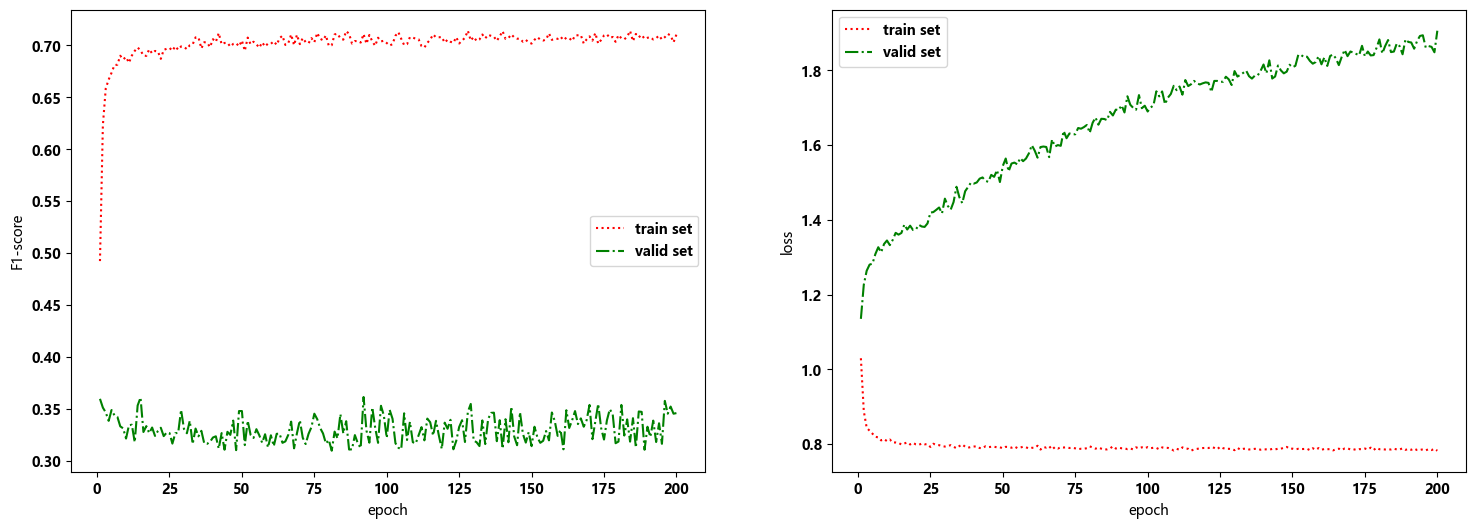

In [8]:
draw_loss(trainrec, validrec)

In [9]:
# 泛化误差估计 + 参数搜索，同时输入多个超参数就是进行模型搜索

from tqdm import tqdm
# 不变的 hyperparameters 
device = 'cpu'
batch_size = 10
lr = 0.01
epochs = 100   # 


# 超参数搜索
playerTrans = 'mlp'
emd_dim = 80 # 40 - 80都很不错，越高越好 
layers = 2
hyperparams = [('mlp', 80, 2), ('random', 80, 2)]
def param_search(hyperparams: list, K=3, Experiment=5):
    pybar = tqdm(total=len(hyperparams) * Experiment * K, desc='what?', unit='exp')
    result = dict()
    for hypers in hyperparams:
        emd_dim = hypers[1] # 40 - 80都很不错，越高越好 
        layers = hypers[2]
        #print(hypers)
        for exp in range(Experiment):
            exp_recorder = Accumulator(2)  # 存train和valid的F1-score，以估计泛化误差和过拟合情况
            mydataset = myDataset(renorm=1) #
            # 补充设置dataset
            playerTrans = hypers[0]  # 从random改回mlp的话，必须重新加载数据集orzzz
            if playerTrans == 'random':
                mydataset.data['cluster'].x = torch.rand((mydataset.data['cluster'].x.shape[0], emd_dim))  # 将这个置为随机
            mydataset.data['squad'].x = torch.rand((mydataset.data['squad'].y.shape[0], emd_dim))   # 无论如何，这个的x都是随机向量

            # k折交叉验证的方式制定train 和 valid 的idx
            for train_mask, valid_mask in mydataset.DataIter(K=K):
                pybar.update(1)
                mydataset.data['squad'].train_mask = train_mask
                mydataset.data['squad'].val_mask = valid_mask
                model = myGraphSAG(mydataset.data, 151, emd_dim=emd_dim, num_layers=layers, palyar_trans=playerTrans, device=device)
                loss = nn.CrossEntropyLoss(label_smoothing=0.1)


                trainloader = NeighborLoader(
                    mydataset.data,
                    # Sample 30 neighbors for each node and edge type for 2 iterations
                    num_neighbors={key: [3] * 2 for key in mydataset.data.edge_types},
                    # Use a batch size of 128 for sampling training nodes of type paper
                    batch_size=batch_size,
                    input_nodes=('squad', mydataset.data['squad'].train_mask), drop_last=True, shuffle=True
                )
                validloader = NeighborLoader(mydataset.data,
                    # Sample 30 neighbors for each node and edge type for 2 iterations
                    num_neighbors={key: [3] * 2 for key in mydataset.data.edge_types},
                    # Use a batch size of 128 for sampling training nodes of type paper
                    batch_size=batch_size,
                    input_nodes=('squad', mydataset.data['squad'].val_mask), drop_last=True, shuffle=True
                )
                trainrec, validrec = train(model, loss, trainloader, validloader, batch_size, epochs, lr, device=device, verbos=0)
                exp_recorder.add(trainrec.read_backup(1)[-1], validrec.read_backup(1)[-1])  # 累加这次试验的F1 score

        trainF1 =  np.array(exp_recorder.data[0])
        validF1 =  np.array(exp_recorder.data[1])
        result[hypers] = (trainF1.mean(), trainF1.std(), validF1.mean(), validF1.std())
        
    return result

#result = param_search(hyperparams)
#print(result)

In [10]:
# 检验是否出现将验证集泄漏到训练集的情况
trai = 0
for b in trainloader:
    trai += b['squad'].batch_size
    
val = 0
for b in validloader:
    val += b['squad'].batch_size
print(trai, val)  # 260 130 没有问题啊，数量对的上 woc，没重合 代码也是按照torch geometry 的api做的
#torch.logical_and(mydataset.data['squad'].train_mask, mydataset.data['squad'].val_mask).sum() # 没有重合
val = 0
for b in trainloader:
    print(b)
    break

260 130
HeteroData(
  cluster={
    x=[453, 151],
    n_id=[453],
  },
  squad={
    y=[248],
    x=[248, 80],
    train_mask=[248],
    n_id=[248],
    input_id=[10],
    batch_size=10,
  },
  (cluster, has player in, squad)={
    edge_index=[2, 100],
    e_id=[100],
  },
  (cluster, connect, cluster)={
    edge_index=[2, 716],
    e_id=[716],
  },
  (squad, has player in, cluster)={
    edge_index=[2, 898],
    e_id=[898],
  }
)


In [11]:
trainloader = NeighborLoader(
    mydataset.data,
    # Sample 20 neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [2] * 2 for key in mydataset.data.edge_types},
    #{('cluster', 'connect', 'cluster'): [10] * 2 , ('cluster', 'has player in', 'squad'): [10, 10], 
     #              ('squad', 'has player in', 'cluster'): []}, 
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=batch_size,
    input_nodes=('squad', mydataset.data['squad'].train_mask), drop_last=True, shuffle=True
)
for b in trainloader:
    print(b['squad'])
    break



AttributeError: 'NodeStorage' object has no attribute 'train_mask'

In [ ]:
mydataset.data['squad']

TypeError: unhashable type: 'slice'

In [ ]:
mydataset.data['squad'].valid_mask

AttributeError: 'NodeStorage' object has no attribute 'valid_mask'

鉴定为，通过这种邻近连接，没有排除全部的表现信息。但这也把我的研究导向了一个我一开始没有设想的方向。也就是说，我实际上证明了mapper是一种低损耗的信息压缩，将表现信息压缩到了这个大网络的mapper中，将支撑球队预测的表现信息压缩到了一个mapper上，并不减少模型的预测效果。可以围绕着这个在更多的情境中探讨，以及查阅下论文，这个idea有没有人以及做过了。